In [1]:
import sys
import os
sys.path.append("/home/lauro/code/msc-thesis/svgd/kernel_learning")
import json_tricks as json
import warnings

import matplotlib as mpl

import jax.numpy as np
from jax import grad, jit, vmap, random, lax, jacfwd
from jax import lax
from jax.ops import index_update, index
import matplotlib.pyplot as plt
import numpy as onp
import jax
import pandas as pd
import haiku as hk

import config

import utils
import metrics
import time
import plot
import svgd
import stein
import kernels
from svgd import SVGD

from jax.experimental import optimizers

rkey = random.PRNGKey(0)
basedir = "/home/lauro/code/msc-thesis/svgd/"

/home/lauro/.virtualenvs/msc-thesis/lib/python3.8/site-packages/jax/lib/xla_bridge.py:125: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


## Summary

In [2]:
def get_data(logdir):
    """Take directory with run results and return a Pandas DataFrame with the relevant hparams plus metrics.
    Returns:
    * frame: a pandas dataframe with config hparams and metrics
    * data: a list of dicts with data collected during runs"""
    cfgs = []
    rundata = []
    metrics = []
    sweep_metaconfigs = []
    base_metaconfigs = []
    for rundir in os.listdir(logdir):
        if os.path.isdir(os.path.join(logdir, rundir)):
            configfile, datafile, metricfile = [logdir + rundir + f for f in ["/config.json", "/rundata.json", "/metrics.json"]]
            try:
                with open(configfile, "r") as f:
                    cfgs.append(json.load(f))
                with open(datafile, "r") as f:
                    rundata.append(json.load(f))
                with open(metricfile, "r") as f:
                    metrics.append(json.load(f))
            except FileNotFoundError:
                warnings.warn(f"Failed loading one or more files from {rundir}.")
        else:
            with open(logdir + rundir, "r") as f:
                base, sweep_config = json.load(f)
                sweep_metaconfigs.append(sweep_config)
                base_metaconfigs.append(base)
     
    # process data
    cfgs_flat = [utils.flatten_dict(c) for c in cfgs]
#     for c in cfgs_flat:
#         c["optimizer_svgd_args"] = onp.squeeze(c["optimizer_svgd_args"])
#         c["optimizer_ksd_args"] = onp.squeeze(c["optimizer_ksd_args"])
    
    
    configs_df = pd.DataFrame(cfgs_flat)
#     configs_df.rename(columns={"optimizer_svgd_args": "lr_svgd", "optimizer_ksd_args": "lr_ksd"}, inplace=True)
    
    metrics_df = pd.DataFrame(metrics)
    all_df = pd.concat([metrics_df, configs_df], axis=1)
    all_df["encoder_layers"] = all_df.encoder_layers.astype('str').astype('category')
    all_df["decoder_layers"] = all_df.decoder_layers.astype('str').astype('category')
    all_df.target_args       = all_df.target_args.astype('str').astype("category")
    all_df["train"] = all_df.train.astype('category')
    
    # to numeric
    all_df.lr_ksd  = pd.to_numeric(all_df.lr_ksd.astype("str"), errors="coerce")
    all_df.lr_svgd = pd.to_numeric(all_df.lr_svgd.astype("str"), errors="coerce")
    
    
    if all_df.isnull().values.any():
        rows_with_nans = all_df.shape[0] - all_df.dropna().shape[0]
        warnings.warn(f"Detected NaNs in dataframe. {rows_with_nans} / {all_df.shape[0]} rows include at least one NaN or inf. Dropping all rows with nonfinite values.")
#         all_df = all_df.dropna()

    return all_df, rundata, cfgs, sweep_metaconfigs, base_metaconfigs

In [3]:
ls ../../leonhard-runs/

2-dim/  2-dim-banana/  aug-4/  aug-5/


In [4]:
rundir = basedir + "leonhard-runs/2-dim-banana/"
frame, rundata, configs, sweep_metaconfigs, base_metaconfigs = get_data(rundir)

<ipython-input-2-d6a638226f18>:22: UserWarning: Failed loading one or more files from 2020-08-08__03:33:22.
  warnings.warn(f"Failed loading one or more files from {rundir}.")
<ipython-input-2-d6a638226f18>:22: UserWarning: Failed loading one or more files from 2020-08-06__00:26:56.
  warnings.warn(f"Failed loading one or more files from {rundir}.")
<ipython-input-2-d6a638226f18>:53: UserWarning: Detected NaNs in dataframe. 471 / 645 rows include at least one NaN or inf. Dropping all rows with nonfinite values.
  warnings.warn(f"Detected NaNs in dataframe. {rows_with_nans} / {all_df.shape[0]} rows include at least one NaN or inf. Dropping all rows with nonfinite values.")


In [5]:
relevant = ["se_mean", "se_var", "ksd", "emd"] + ["lr_ksd", "lr_svgd", "svgd_steps", "encoder_layers", "ksd_steps", "train", "lambda_reg", "minimize_ksd_variance"]
f = frame[relevant]
# f

In [6]:
f.emd.describe()

count    644.000000
mean       2.819738
std        2.855724
min        0.000000
25%        0.000000
50%        2.304760
75%        5.068168
max        8.337160
Name: emd, dtype: float64

In [7]:
f.se_mean.describe()

count    384.000000
mean      11.508193
std       10.785421
min        0.191964
25%        1.584095
50%        8.008300
75%       20.213802
max       32.360256
Name: se_mean, dtype: float64

# Investigate cause of NaNs

In [64]:
f.isnull()["se_mean"]

0       True
1      False
2       True
3      False
4      False
       ...  
640     True
641    False
642     True
643    False
644     True
Name: se_mean, Length: 645, dtype: bool

In [65]:
nan_idx = onp.asarray(f.isnull()["se_mean"])

In [70]:
rundata_nan = onp.asarray(rundata)[nan_idx]
rundata_clean = onp.asarray(rundata)[onp.logical_not(nan_idx)]
f_nan = f[nan_idx]
f_clean = f[onp.logical_not(nan_idx)]

... and here's our cause. Too large SVGD learning rate.

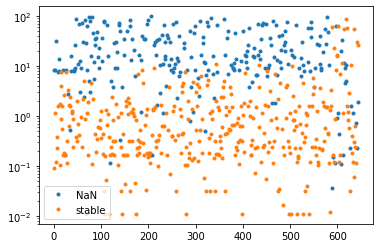

In [71]:
plt.plot(f_nan.lr_svgd, ".", label="NaN")
plt.plot(f_clean.lr_svgd, ".", label="stable")
plt.yscale("log")
plt.legend()

An interesting fact: vanilla runs tend to be slightly more stable.

In [72]:
print("Unstable runs:")
print("train:", f_nan[f_nan.train].shape[0])
print("vanilla:", f_nan[f_nan.train == False].shape[0])

Unstable runs:
train: 216
vanilla: 45


In [73]:
print("Stable runs:")
print("train:", f_clean[f_clean.train].shape[0])
print("vanilla:", f_clean[f_clean.train == False].shape[0])

Stable runs:
train: 299
vanilla: 85


Here's a plot of stability vs. train/vanilla vs SVGD learning rate.

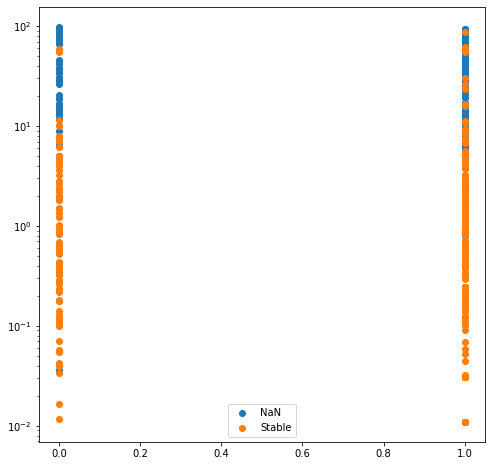

In [74]:
fig, ax = plt.subplots(figsize=[8,8])
ax.scatter(f_nan.train, f_nan.lr_svgd, label="NaN")
ax.scatter(f_clean.train, f_clean.lr_svgd, label="Stable")
ax.set_yscale("log")
ax.legend()

# Hyperparameter comparison

In [79]:
f = f_clean

## Just vanilla

Clear trend for the SVGD learning rate (which is the only difference between the vanilla runs).

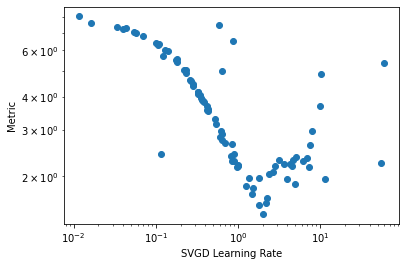

In [82]:
v = f[f.train == False]
plt.scatter(v.lr_svgd, v.emd)
plt.xlabel("SVGD Learning Rate")
plt.ylabel("Metric")
plt.xscale("log")
plt.yscale("log")

# Vanilla + MLP

## SVGD LR
Again, a clear trend for SVGD learning rate.
Also seems that the bigger nets train more slowly, maybe need more training steps.

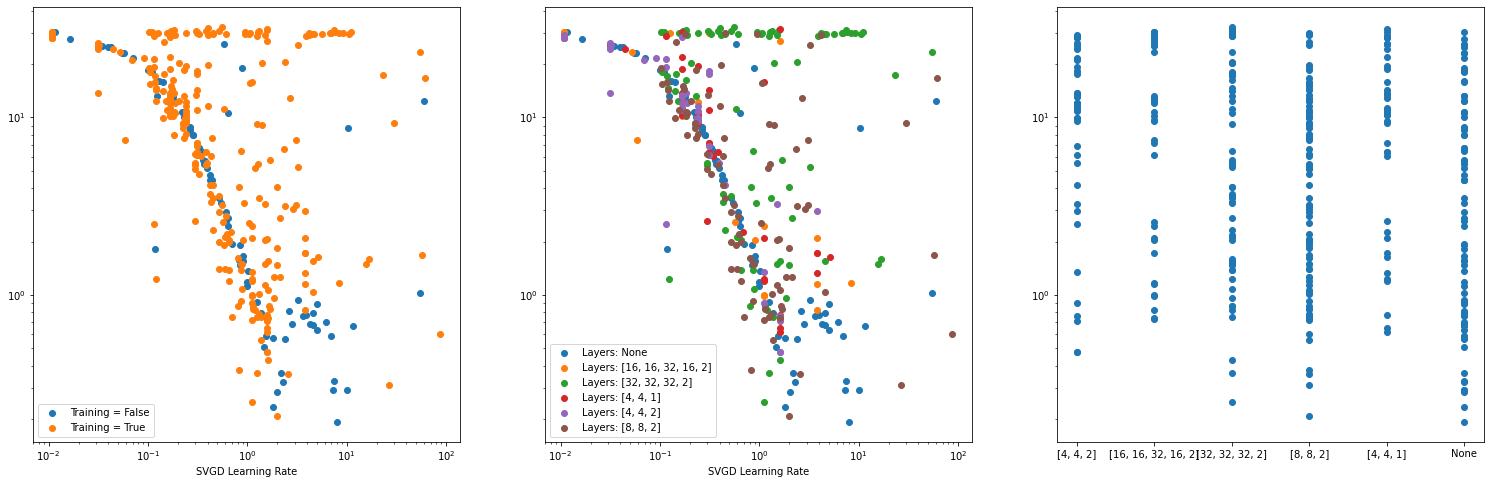

In [83]:
fig, axs = plt.subplots(1, 3, figsize=[26,8])
for ax, grouplabel, prefix in zip(axs, ("train", "encoder_layers"), ("Training = ", "Layers: ")):
    groups = f.groupby(grouplabel)
    for name, group in groups:
        ax.scatter(group.lr_svgd, group.se_mean, marker="o", label=prefix + str(name))
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.legend()
    _ = ax.set_xlabel("SVGD Learning Rate")

axs[2].scatter(f.encoder_layers, f.se_mean)
axs[2].set_yscale("log")

# Just MLP

In [84]:
f = f[f.train]

## Lambda
The Autoencoder regularization parameter is important:

Unfortunately, I didn't sample small enough (will fix in next run).

(0.004, 100.0)

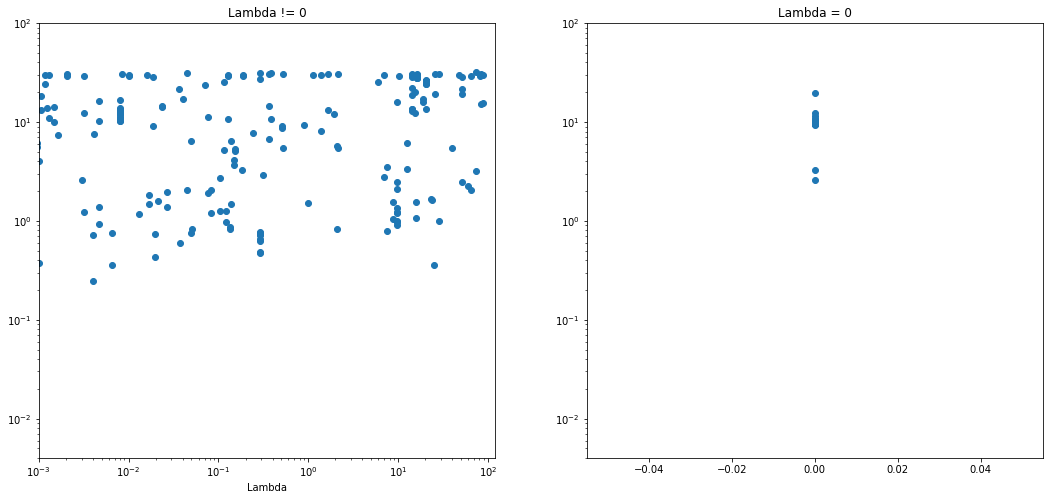

In [85]:
fig, axs = plt.subplots(1, 2, figsize=[18,8])
ax = axs[0]
ax.set_title("Lambda != 0")
ax.scatter(f.lambda_reg, f.se_mean)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(0.001, 120)
ax.set_ylim(0.004, 100)
ax.set_xlabel("Lambda")

ax = axs[1]
ax.set_title("Lambda = 0")
ax.scatter(f[f.lambda_reg==0].lambda_reg, f[f.lambda_reg==0].se_mean)
ax.set_yscale("log")
ax.set_ylim(axs[0].get_ylim())

For next plots, leave out shitty unregularized results.

In [16]:
f = f[f.lambda_reg != 0]

## KSD Variance

No effect (or slightly negative)

(0.1, 100)

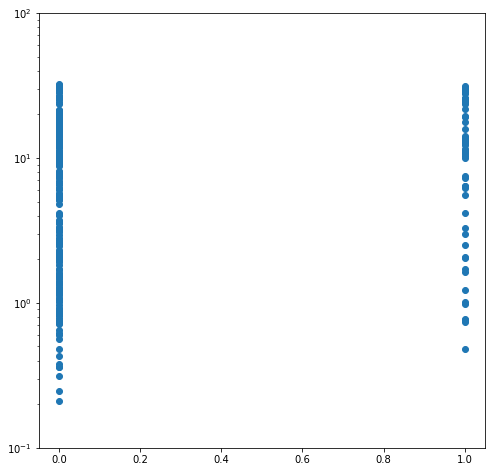

In [86]:
fig, ax = plt.subplots(figsize=[8,8])
ax.scatter(f.minimize_ksd_variance, f.se_mean)
ax.set_yscale("log")
ax.set_ylim(0.1, 100)

## Encoder / decoder LR

This learning rate is also important. Tho need more data here too.

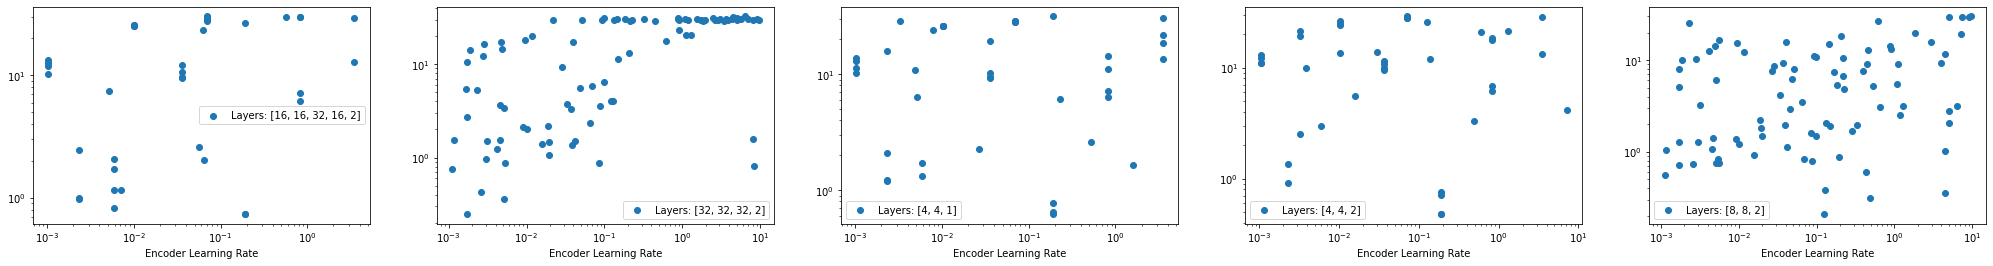

In [104]:
groups = f.groupby(grouplabel)
fig, axs = plt.subplots(1, len(groups)-1, figsize=[35,4])
groups = iter(groups) # skip empty vanilla group
next(groups)
for [name, group], ax in zip(groups, axs):
    ax.scatter(group.lr_ksd, group.se_mean, marker="o", label=prefix + str(name))
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.legend()
    _ = ax.set_xlabel("Encoder Learning Rate")

# Rundata

In [22]:
ind = 2
f.iloc[ind]

se_mean                                                           0.770781
se_var                                                             6.61634
ksd                                                              0.0219937
emd                                                                2.06606
lr_ksd                                                            0.191165
lr_svgd                                                            1.59546
svgd_steps                                                               1
encoder_layers                                                   [4, 4, 1]
ksd_steps                                                               10
train                                                                 True
lambda_reg                                                        0.288901
target_args              [[[-1.0, 1.0], [-2.0, 3.0314331330207964], [-1...
minimize_ksd_variance                                                 True
Name: 2, dtype: object

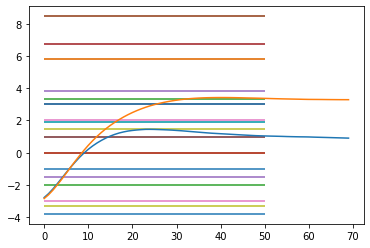

In [23]:
colorcycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
mean = onp.array(rundata[ind]["training_mean"])
tru_mean = configs[ind]["svgd"]["target_args"][0]

_ = plt.plot(mean)
_ = plt.hlines(tru_mean, 0, 50, colors=colorcycle)

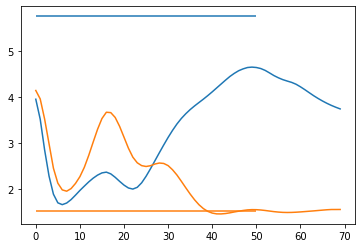

In [31]:
var = onp.array(rundata[ind]["training_var"])
tru_var = onp.diag(configs[ind]["svgd"]["target_args"][1])
_ = plt.plot(var)
_ = plt.hlines(tru_var, 0, 50, colors=colorcycle)